In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt

os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon\alpiq-datathon-2025-main\datasets2025')

data = pd.read_csv('training_set_ES.csv')
metering_ES = pd.read_csv('historical_metering_data_ES.csv', index_col=0)

data.index = metering_ES.index

assert data.isna().sum().sum() == 0

print('Shape:', data.shape)
print('Cols:', data.columns)

Shape: (22629, 199)
Cols: Index(['VALUEMWHMETERINGDATA_customerES_1',
       'VALUEMWHMETERINGDATA_customerES_2',
       'VALUEMWHMETERINGDATA_customerES_5',
       'VALUEMWHMETERINGDATA_customerES_11',
       'VALUEMWHMETERINGDATA_customerES_19',
       'VALUEMWHMETERINGDATA_customerES_30',
       'VALUEMWHMETERINGDATA_customerES_31',
       'VALUEMWHMETERINGDATA_customerES_39',
       'VALUEMWHMETERINGDATA_customerES_40',
       'VALUEMWHMETERINGDATA_customerES_44',
       ...
       'INITIALROLLOUTVALUE_customerES_307',
       'INITIALROLLOUTVALUE_customerES_311',
       'INITIALROLLOUTVALUE_customerES_312',
       'INITIALROLLOUTVALUE_customerES_313',
       'INITIALROLLOUTVALUE_customerES_334',
       'INITIALROLLOUTVALUE_customerES_335',
       'INITIALROLLOUTVALUE_customerES_336', 'is_holiday', 'spv', 'temp'],
      dtype='object', length=199)


In [2]:
X = data.iloc[:-1,:].copy()
Y = data[metering_ES.columns].shift(-1).iloc[:-1,:].copy()

assert X.isna().sum().sum() == 0 and Y.isna().sum().sum() == 0

In [ ]:
### Add Categorical Vars

X.index = pd.to_datetime(X.index)

month = X.index.month
weekday = X.index.weekday
hour = X.index.hour

X.loc[:,'month_sin'] = np.sin(2 * np.pi * month / 12)
X.loc[:,'month_cos'] = np.cos(2 * np.pi * month / 12)
X.loc[:,'day_sin'] = np.sin(2 * np.pi * weekday / 7)
X.loc[:,'day_cos'] = np.cos(2 * np.pi * weekday / 7)
X.loc[:,'hour_sin'] = np.sin(2 * np.pi * hour / 24)
X.loc[:,'hour_cos'] = np.cos(2 * np.pi * hour / 24)

cols_cat = [
    'month_sin','month_cos',
    'day_sin','day_cos',
    'hour_sin','hour_cos'
            ]

In [4]:
# Set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def plot_loss(train_losses, val_losses):
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 3 columns
    # First plot: Loss evolution (val loss alone)
    axes[0].set_title('Loss evolution (val loss alone)')
    axes[0].plot(train_losses, label='validation', marker='o')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[1].set_title('Loss evolution (val loss alone)')
    axes[1].plot(val_losses, label='validation', marker='o')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

In [5]:
os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon')

from models import xLSTMModel, TransformerDecoderOnly

Epoch 1/500, Train Loss: 0.1420, Val Loss: 0.1038
Epoch 2/500, Train Loss: 0.0953, Val Loss: 0.0966
Epoch 3/500, Train Loss: 0.0849, Val Loss: 0.0920
Epoch 4/500, Train Loss: 0.0787, Val Loss: 0.0885
Epoch 5/500, Train Loss: 0.0758, Val Loss: 0.0876
Epoch 6/500, Train Loss: 0.0735, Val Loss: 0.0863
Epoch 7/500, Train Loss: 0.0709, Val Loss: 0.0850
Epoch 8/500, Train Loss: 0.0683, Val Loss: 0.0834
Epoch 9/500, Train Loss: 0.0666, Val Loss: 0.0830
Epoch 10/500, Train Loss: 0.0649, Val Loss: 0.0815
Epoch 11/500, Train Loss: 0.0635, Val Loss: 0.0804
Epoch 12/500, Train Loss: 0.0624, Val Loss: 0.0801
Epoch 13/500, Train Loss: 0.0616, Val Loss: 0.0795
Epoch 14/500, Train Loss: 0.0608, Val Loss: 0.0793
Epoch 15/500, Train Loss: 0.0600, Val Loss: 0.0793
Epoch 16/500, Train Loss: 0.0593, Val Loss: 0.0784
Epoch 17/500, Train Loss: 0.0586, Val Loss: 0.0781
Epoch 18/500, Train Loss: 0.0581, Val Loss: 0.0779
Epoch 19/500, Train Loss: 0.0575, Val Loss: 0.0772
Epoch 20/500, Train Loss: 0.0569, Val Lo

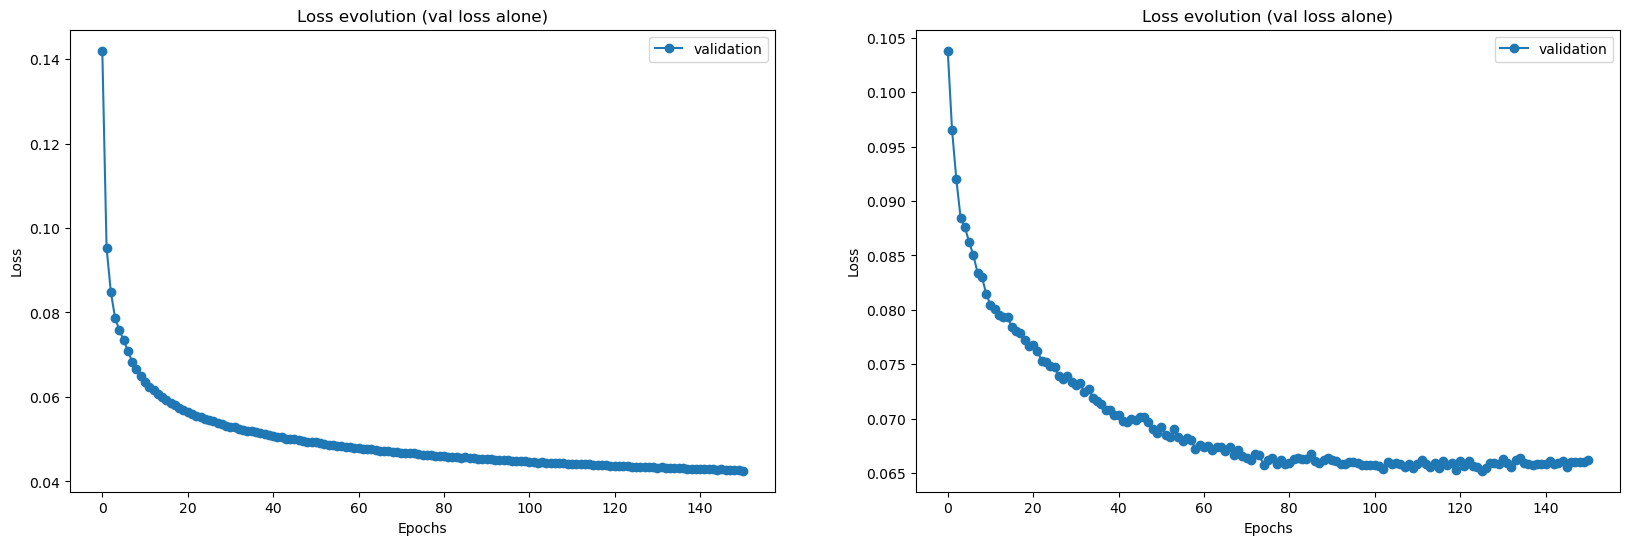

In [6]:
seed = 1  # You can choose any integer value
set_seed(seed)

# Split the data into training (first 80%) and validation (last 20%)
split_idx = int(0.9 * len(X))  # Calculate the split index

# Standardize the data
scaler_X = StandardScaler()
scaler_Y = MinMaxScaler()

# Fit the scalers on the training data and transform both training and validation data
X_train = scaler_X.fit_transform(X.drop(cols_cat, axis=1).iloc[:split_idx])
X_val = scaler_X.transform(X.drop(cols_cat, axis=1).iloc[split_idx:])
Y_train = scaler_Y.fit_transform(Y.iloc[:split_idx])
Y_val = scaler_Y.transform(Y.iloc[split_idx:])

X_train_cat = X[cols_cat].iloc[:split_idx]
X_val_cat = X[cols_cat].iloc[split_idx:]

X_train = np.concatenate([X_train, X_train_cat], axis=1)
X_val = np.concatenate([X_val, X_val_cat], axis=1)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader for batching
batch_size = 200

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_dim = X_train.shape[1]  # Number of features (e.g., energy consumption + naive forecasts)
hidden_dim = 168  # Increased hidden dimension for better capacity # (24,168)
output_dim = Y_train.shape[1]  # Number of firms (or target variables)
num_layers = 3  # Deeper LSTM
dropout = 0.3  # Dropout to prevent overfitting
max_grad_norm = 5.0  # Maximum gradient norm for clipping

# Initialize the model, loss function, and optimizer
model = xLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
num_epochs = 500
best_val_loss = float('inf')
patience = 25
epochs_no_improve = 0
best_model_path = "best_lstm_model_ES.pth"

train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
        loss = criterion(outputs, Y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded.")
plot_loss(train_losses, val_losses)

In [7]:
model_save_ES = model

In [13]:
# Load test data
os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon\alpiq-datathon-2025-main\datasets2025')
test_ = pd.read_csv('forecast_set_ES_weather.csv', index_col=0, parse_dates=True)

# Merge historical data with test data
test = pd.concat([data, test_], axis=0)
test = test.loc[:,data.columns]

# Ensure the index is sorted (important for time series)
test.index = pd.to_datetime(test.index)
test = test.sort_index()

# Add cyclical features to test data
month = test.index.month
weekday = test.index.weekday
hour = test.index.hour

test['month_sin'] = np.sin(2 * np.pi * month / 12)
test['month_cos'] = np.cos(2 * np.pi * month / 12)
test['day_sin'] = np.sin(2 * np.pi * weekday / 7)
test['day_cos'] = np.cos(2 * np.pi * weekday / 7)
test['hour_sin'] = np.sin(2 * np.pi * hour / 24)
test['hour_cos'] = np.cos(2 * np.pi * hour / 24)

# Initialize an empty DataFrame to store predictions
predictions = pd.DataFrame(index=test_.index, columns=Y.columns)

# Define sequence length (e.g., 168 for weekly patterns)
seq_length = 168

# Loop through each row in test_
for i, timestamp in enumerate(test_.index):

    # Define the input sequence for the model
    start_idx = test.index.get_loc(timestamp) - seq_length
    end_idx = test.index.get_loc(timestamp)
    input_sequence = test.iloc[start_idx:end_idx]

    # Standardize the input sequence (use the scaler fitted on training data)
    input_sequence_scaled = scaler_X.transform(
        input_sequence.drop(cols_cat, axis=1)
        )
    input_sequence_scaled = np.concatenate(
        [input_sequence_scaled, input_sequence[cols_cat]], axis=1
        )

    # Convert to PyTorch tensor and add batch and sequence dimensions
    input_tensor = torch.tensor(input_sequence_scaled, dtype=torch.float32).unsqueeze(0)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        predicted_values = model(input_tensor).squeeze(0).numpy()

    # Inverse transform the predictions to the original scale
    predicted_values_original = scaler_Y.inverse_transform(predicted_values.reshape(1, -1))[0]

    # Store the predictions
    predictions.loc[timestamp] = predicted_values_original

    # Update the test DataFrame with the predicted values
    test.loc[timestamp, Y.columns] = predicted_values_original

# The `predictions` DataFrame now contains the forecasted values for `test_`

In [14]:
test = test.loc[test_.index[0]:,:]
test.to_csv('predictions_ES.csv', index=True)

# APPENDIX

Epoch 1/500, Train Loss: 0.5999, Val Loss: 0.5153
Epoch 2/500, Train Loss: 0.5024, Val Loss: 0.4907
Epoch 3/500, Train Loss: 0.4718, Val Loss: 0.4719
Epoch 4/500, Train Loss: 0.4443, Val Loss: 0.4559
Epoch 5/500, Train Loss: 0.4231, Val Loss: 0.4398
Epoch 6/500, Train Loss: 0.4064, Val Loss: 0.4271
Epoch 7/500, Train Loss: 0.3911, Val Loss: 0.4062
Epoch 8/500, Train Loss: 0.3736, Val Loss: 0.4003
Epoch 9/500, Train Loss: 0.3623, Val Loss: 0.3933
Epoch 10/500, Train Loss: 0.3541, Val Loss: 0.3910
Epoch 11/500, Train Loss: 0.3485, Val Loss: 0.3901
Epoch 12/500, Train Loss: 0.3419, Val Loss: 0.3867
Epoch 13/500, Train Loss: 0.3348, Val Loss: 0.3794
Epoch 14/500, Train Loss: 0.3290, Val Loss: 0.3759
Epoch 15/500, Train Loss: 0.3247, Val Loss: 0.3718
Epoch 16/500, Train Loss: 0.3218, Val Loss: 0.3706
Epoch 17/500, Train Loss: 0.3193, Val Loss: 0.3665
Epoch 18/500, Train Loss: 0.3167, Val Loss: 0.3670
Epoch 19/500, Train Loss: 0.3151, Val Loss: 0.3657
Epoch 20/500, Train Loss: 0.3133, Val Lo

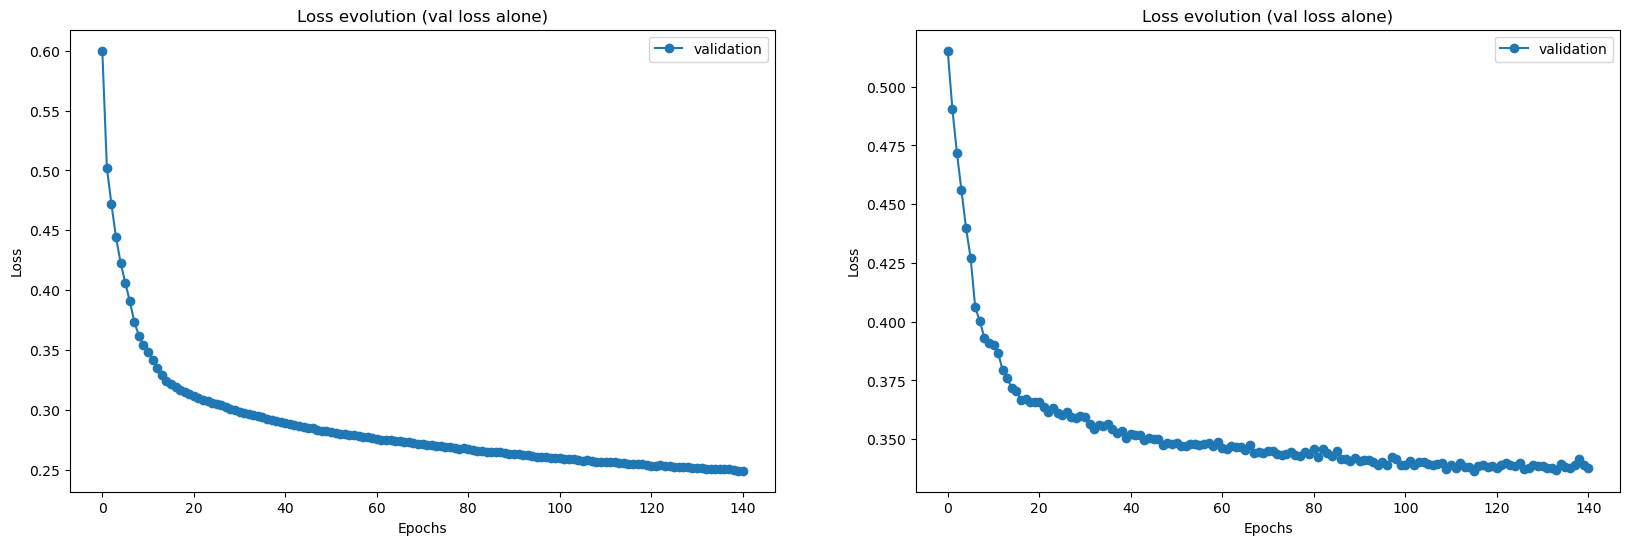

In [ ]:
seed = 1  # You can choose any integer value
set_seed(seed)

# Split the data into training (first 80%) and validation (last 20%)
split_idx = int(0.8 * len(X))  # Calculate the split index

# Standardize the data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit the scalers on the training data and transform both training and validation data
X_train = scaler_X.fit_transform(X.drop(cols_cat, axis=1).iloc[:split_idx])
X_val = scaler_X.transform(X.drop(cols_cat, axis=1).iloc[split_idx:])
Y_train = scaler_Y.fit_transform(Y.iloc[:split_idx])
Y_val = scaler_Y.transform(Y.iloc[split_idx:])

X_train_cat = X[cols_cat].iloc[:split_idx]
X_val_cat = X[cols_cat].iloc[split_idx:]

X_train = np.concatenate([X_train, X_train_cat], axis=1)
X_val = np.concatenate([X_val, X_val_cat], axis=1)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader for batching
batch_size = 200

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_dim = X_train.shape[1]  # Number of features (e.g., energy consumption + naive forecasts)
hidden_dim = 168  # Increased hidden dimension for better capacity # (24,168)
output_dim = Y_train.shape[1]  # Number of firms (or target variables)
num_layers = 3  # Deeper LSTM
dropout = 0.3  # Dropout to prevent overfitting
max_grad_norm = 5.0  # Maximum gradient norm for clipping

# dropout = 0.5: BAD
# batch_size = 300: BAD

# Initialize the model, loss function, and optimizer
model = xLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
num_epochs = 500
best_val_loss = float('inf')
patience = 25
epochs_no_improve = 0
best_model_path = "best_lstm_model.pth"

train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
        loss = criterion(outputs, Y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded.")
plot_loss(train_losses, val_losses)

Epoch 1/500, Train Loss: 0.4208, Val Loss: 0.4184
Epoch 2/500, Train Loss: 0.3049, Val Loss: 0.3944
Epoch 3/500, Train Loss: 0.2710, Val Loss: 0.3817
Epoch 4/500, Train Loss: 0.2511, Val Loss: 0.3619
Epoch 5/500, Train Loss: 0.2366, Val Loss: 0.3586
Epoch 6/500, Train Loss: 0.2254, Val Loss: 0.3459
Epoch 7/500, Train Loss: 0.2161, Val Loss: 0.3390
Epoch 8/500, Train Loss: 0.2087, Val Loss: 0.3311
Epoch 9/500, Train Loss: 0.2023, Val Loss: 0.3284
Epoch 10/500, Train Loss: 0.1968, Val Loss: 0.3259
Epoch 11/500, Train Loss: 0.1918, Val Loss: 0.3196
Epoch 12/500, Train Loss: 0.1876, Val Loss: 0.3180
Epoch 13/500, Train Loss: 0.1843, Val Loss: 0.3174
Epoch 14/500, Train Loss: 0.1811, Val Loss: 0.3144
Epoch 15/500, Train Loss: 0.1782, Val Loss: 0.3130
Epoch 16/500, Train Loss: 0.1754, Val Loss: 0.3122
Epoch 17/500, Train Loss: 0.1733, Val Loss: 0.3086
Epoch 18/500, Train Loss: 0.1712, Val Loss: 0.3067
Epoch 19/500, Train Loss: 0.1687, Val Loss: 0.3056
Epoch 20/500, Train Loss: 0.1671, Val Lo

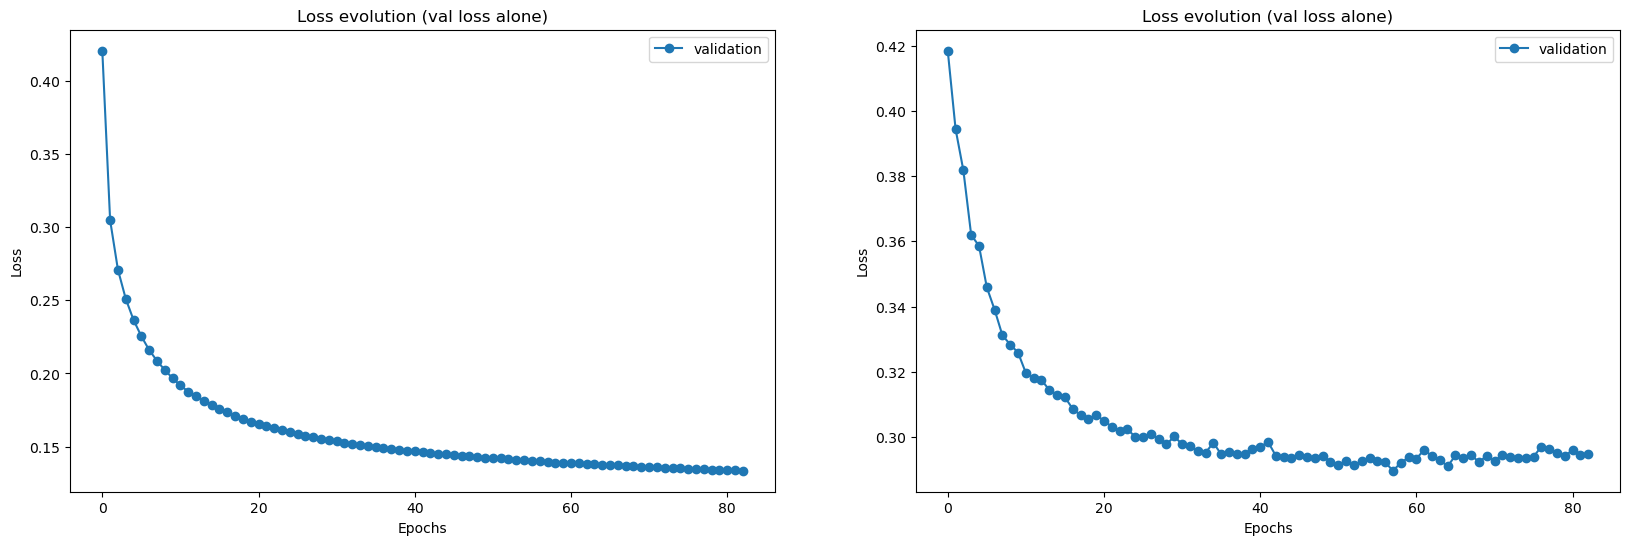

In [81]:
def create_sequences(X, Y, seq_length):
    """
    Create sequences of input features (X) and target values (Y) for transformer training.
    """
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        Y_seq.append(Y[i+seq_length])  # Predict the next hour's consumption
    return np.array(X_seq), np.array(Y_seq)

# Define sequence length (e.g., 24 hours)
seq_length = 24

# Prepare training and validation sequences
X_train_seq, Y_train_seq = create_sequences(X_train, Y_train, seq_length)
X_val_seq, Y_val_seq = create_sequences(X_val, Y_val, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_seq, dtype=torch.float32)

# Create DataLoader for batching
batch_size = 200

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

############################################################################

# Model parameters
input_dim = X_train.shape[1]  # Number of features (e.g., energy consumption + naive forecasts)
hidden_dim = 128  # Hidden dimension of the transformer
num_heads = 4  # Number of attention heads
num_layers = 3  # Number of transformer decoder layers
output_dim = Y_train.shape[1]  # Number of target variables (e.g., firms)
dropout = 0.1  # Dropout rate
max_seq_len = seq_length  # Maximum sequence length

# Initialize the transformer model
model = TransformerDecoderOnly(input_dim, hidden_dim, num_heads, num_layers, output_dim, dropout, max_seq_len)
criterion = nn.L1Loss()  # Mean Absolute Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
num_epochs = 100
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
best_model_path = "best_transformer_model.pth"

train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)  # No need to add sequence dimension
        loss = criterion(outputs, Y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded.")
plot_loss(train_losses, val_losses)


In [128]:
os.chdir(r'C:\Users\Lorenzo\OneDrive - Universitaet St.Gallen\Desktop\ACE Datathon\alpiq-datathon-2025-main\datasets2025')
test_ = pd.read_csv('forecast_set_ES_new.csv', index_col=0, parse_dates=True)

# Merge historical data with test data
test = pd.concat([data, test_], axis=0)

test.index = pd.to_datetime(test.index)

month = test.index.month
weekday = test.index.weekday
hour = test.index.hour

test.loc[:,'month_sin'] = np.sin(2 * np.pi * month / 12)
test.loc[:,'month_cos'] = np.cos(2 * np.pi * month / 12)
test.loc[:,'day_sin'] = np.sin(2 * np.pi * weekday / 7)
test.loc[:,'day_cos'] = np.cos(2 * np.pi * weekday / 7)
test.loc[:,'hour_sin'] = np.sin(2 * np.pi * hour / 24)
test.loc[:,'hour_cos'] = np.cos(2 * np.pi * hour / 24)

# Ensure the index is sorted (important for time series)
test = test.sort_index()

# Initialize an empty DataFrame to store predictions
predictions = pd.DataFrame(index=test_.index, columns=Y.columns)

# Define sequence length (e.g., 168 for weekly patterns)
seq_length = 24

# Loop through each row in test_
for i, timestamp in enumerate(test_.index):

    # Define the input sequence for the model
    start_idx = test.index.get_loc(timestamp) - seq_length
    end_idx = test.index.get_loc(timestamp)
    input_sequence = test.iloc[start_idx:end_idx]

    # Standardize the input sequence (use the scaler fitted on training data)
    input_sequence_scaled = scaler_X.transform(
        input_sequence.drop(cols_cat, axis=1)
        )
    input_sequence_scaled = np.concatenate(
        [input_sequence_scaled, input_sequence[cols_cat]], axis=1
        )

    # Convert to PyTorch tensor and add batch and sequence dimensions
    input_tensor = torch.tensor(input_sequence_scaled, dtype=torch.float32).unsqueeze(0)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        predicted_values = model(input_tensor).squeeze(0).numpy()

    # Inverse transform the predictions to the original scale
    predicted_values_original = scaler_Y.inverse_transform(predicted_values.reshape(1, -1))[0]

    # Store the predictions
    predictions.loc[timestamp] = predicted_values_original

    # Update the test DataFrame with the predicted values
    test.loc[timestamp, Y.columns] = predicted_values_original

# The `predictions` DataFrame now contains the forecasted values for `test_`


In [132]:
test = test.loc[test_.index[0]:,:]
test.to_csv('predictions_ES.csv', index=True)